# 1. Download Dataset

Download these two datasets from google

# 2. Importing libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
movies = pd.read_csv("dataset/movies.csv")
ratings = pd.read_csv("dataset/ratings.csv")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# 3. Preprocessing

## Cleaning movies dataframe

In [7]:
unique = set()
for index,row in movies.iterrows():
    li = (row['genres']).split('|')
    for i in li:
        unique.add(i)
unique

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In movies.generes there are words like sci-fi and no-genere-listed So we will replace them, replace '|' and make them simple words which will be easy to convert into vectors later

In [8]:
movies.genres = movies.genres.apply(lambda x : x.lower().replace('|',' '))
movies.genres = movies.genres.apply(lambda x : x.replace('sci-fi','sciencefiction'))
movies.genres = movies.genres.apply(lambda x : x.replace('film-noir','filmnoir'))
movies.loc[movies['genres'].str.contains('no') & ~movies['genres'].str.contains('filmnoir'), 'genres'] = 'drama'

In [71]:
movies[movies['genres'].str.contains('no') & ~movies['genres'].str.contains('filmnoir')]

,index,movieId,title,genres


Correcting title format

In [72]:
import re

In [75]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)

In [77]:
movies['title'] = movies['title'].str.replace(r'\((\d{4})\)','',regex = True)

In [78]:
movies.head(1)

,index,movieId,title,genres,year
0,0,1,Toy Story,adventure animation children comedy fantasy,1995


In [79]:
movies[movies.title.str.endswith('The')]

,index,movieId,title,genres,year


In [145]:
movies.loc[movies.title.str.endswith('The')]

,movieId,title,genres,year
10,11,"American President, The",comedy drama romance,1995
46,50,"Usual Suspects, The",crime mystery thriller,1995
49,54,"Big Green, The",children comedy,1995
53,60,"Indian in the Cupboard, The",adventure children fantasy,1995
70,78,"Crossing Guard, The",action crime drama thriller,1995
...,...,...,...,...
8723,127180,"Story of Film: An Odyssey, The",documentary,2011
8790,130578,"Gunman, The",action thriller,2015
9000,140523,"Visit, The",comedy horror,2015
9102,145935,"Peanuts Movie, The",adventure animation children comedy,2015


In [82]:
movies.loc[mask, 'title'] = movies.loc[mask, 'title'].str.replace(r', The$', '', regex=True).str.strip()  # Remove ', The'
movies.loc[mask, 'title'] = 'The ' + movies.loc[mask, 'title']  # Add 'The' at the beginning

In [83]:
movies.title = movies.title.str.strip()

In [85]:
movies.head()

,index,movieId,title,genres,year
0,0,1,Toy Story,adventure animation children comedy fantasy,1995
1,1,2,Jumanji,adventure children fantasy,1995
2,2,3,Grumpier Old Men,comedy romance,1995
3,3,4,Waiting to Exhale,comedy drama romance,1995
4,4,5,Father of the Bride Part II,comedy,1995


### Updating csv file for furthur uses

In [86]:
movies.to_csv('dataset/updated_movies.csv',index=False)

# 4. Some EDA

Getting highest rating counts 

In [10]:
grouped_count = ratings.groupby('movieId').size().reset_index(name='rating_count')
grouped_count.sort_values(by=['rating_count'],ascending=False)

,movieId,rating_count
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
...,...,...
3053,4093,1
3049,4089,1
6687,58351,1
3045,4083,1


In [14]:
movie_121_count = grouped_count[grouped_count['movieId'] == 182727]
print(movie_121_count)

      movieId  rating_count
9651   182727             1


# Modelling - Creating matrix from which we will get recommendations

In [15]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### Checking how many users have rated movies how many times altough I will add all the data since the data itself is very short

In [19]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

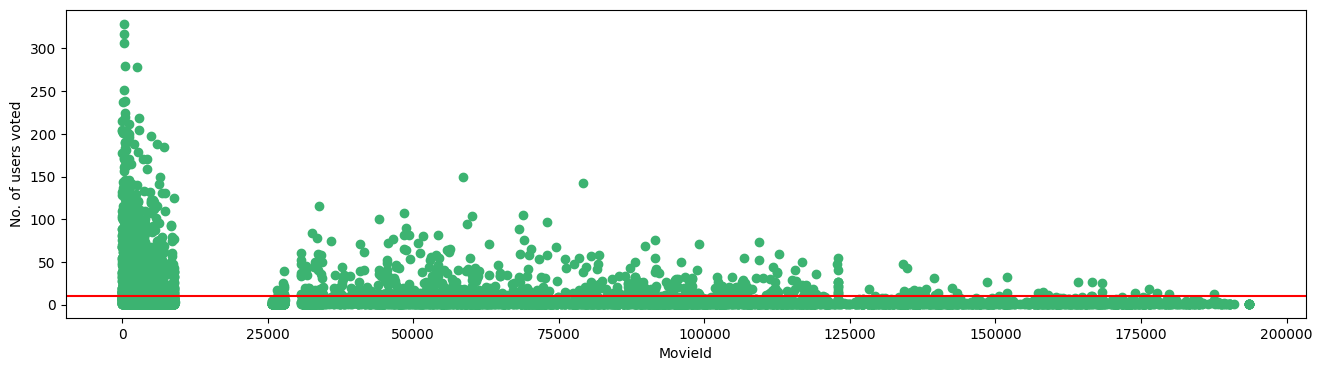

In [21]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [36]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:] # Noooo

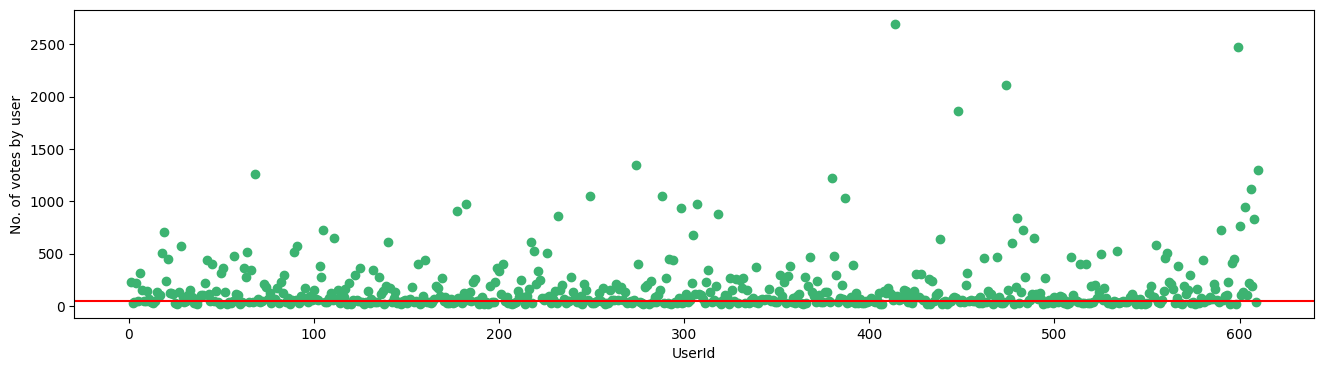

In [22]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [38]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Getting Recommendations

## We will be seeing 2 approaches to get results
### 1. KNN - K Nearest Neighbors algorithm
### 2. FAISS - A vector database library from facebook for fast retrival of similar vectors

### 1.KNN

KNN works faster on condensed matrices instead of large matrices with almost zeros everywhere

In [27]:
csr_data = csr_matrix(final_dataset.values) # Convert to consensed matrix form
final_dataset.reset_index(inplace=True)

In [28]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

A function to get recommendations

In [183]:
movie_Id = movies[movies['title'] == 'Avengers, The (2012)']['movieId'].values[0]
movie_Id

89745

In [184]:
row_sparse = final_dataset[final_dataset['movieId'] == movie_Id].index[0]
row_sparse

1961

In [185]:
_ , indices= knn.kneighbors(csr_data[row_sparse],n_neighbors=10)

In [186]:
recommended_movie_ids = final_dataset.iloc[indices.flatten()]['movieId']
movie_names = []
for i in recommended_movie_ids:
    movie_names.append(movies[movies['movieId'] == i])

In [ ]:
movie_names

In [56]:
def recommend(movie):
    movie_Id = movies[movies['title'] == movie]['movieId'].values[0]
    row_sparse = final_dataset[final_dataset['movieId'] == movie_Id].index[0]
    _ , indices= knn.kneighbors(csr_data[row_sparse],n_neighbors=15)
    recommended_movie_ids = final_dataset.iloc[indices.flatten()]['movieId']
    movie_names = []
    for i in recommended_movie_ids:
        movie_names.append(movies[movies['movieId'] == i].title)
    return movie_names[1:]

In [57]:
recommend('Inception (2010)')

[7768    Dark Knight Rises, The (2012)
 Name: title, dtype: object,
 7258    Shutter Island (2010)
 Name: title, dtype: object,
 8376    Interstellar (2014)
 Name: title, dtype: object,
 7693    Avengers, The (2012)
 Name: title, dtype: object,
 7010    Inglourious Basterds (2009)
 Name: title, dtype: object,
 8063    Django Unchained (2012)
 Name: title, dtype: object,
 7413    Social Network, The (2010)
 Name: title, dtype: object,
 7214    Sherlock Holmes (2009)
 Name: title, dtype: object,
 7395    Scott Pilgrim vs. the World (2010)
 Name: title, dtype: object,
 7955    Skyfall (2012)
 Name: title, dtype: object,
 7324    Iron Man 2 (2010)
 Name: title, dtype: object,
 7043    Hangover, The (2009)
 Name: title, dtype: object,
 8475    Guardians of the Galaxy (2014)
 Name: title, dtype: object,
 7039    Up (2009)
 Name: title, dtype: object]

### 2.FAISS

FAISS needs all vector data instead of sparse dataset so here it is

In [59]:
import faiss

In [58]:
dense_matrix = final_dataset.values.astype(np.float32)

In [36]:
faiss.normalize_L2(dense_matrix)

In [60]:
dim = dense_matrix.shape[1] 
index = faiss.IndexFlatIP(dim)
index.add(dense_matrix)

In [67]:
movies.reset_index(inplace=True)

In [69]:
def recommendfaiss(movie):
    movieId = int(movies.loc[movies.title == movie].index[0])
    query_vector = index.reconstruct(movieId).reshape(1,-1)
    D, indices = index.search(query_vector, 15)
    movie_names = []
    for i in indices:
        movie_names.append(movies.iloc[i])
    return movie_names

recommendfaiss('Inception (2010)')

[      index  movieId                                  title  \
 9723   9723   189713                  BlacKkKlansman (2018)   
 9722   9722   189547                    Iron Soldier (2010)   
 9721   9721   189381                        SuperFly (2018)   
 9720   9720   189333   Mission: Impossible - Fallout (2018)   
 9719   9719   189111                          Spiral (2018)   
 9718   9718   189043                      Boundaries (2018)   
 9717   9717   188833  The Man Who Killed Don Quixote (2018)   
 9716   9716   188797                             Tag (2018)   
 9715   9715   188751    Mamma Mia: Here We Go Again! (2018)   
 9714   9714   188675                          Dogman (2018)   
 9713   9713   188301            Ant-Man and the Wasp (2018)   
 9712   9712   188189             Sorry to Bother You (2018)   
 9711   9711   187717       Won't You Be My Neighbor? (2018)   
 9710   9710   187595         Solo: A Star Wars Story (2018)   
 9709   9709   187593                   

In [111]:
faiss.write_index(index, "faiss_index_file.idx")

# Its Done , follwoing cells are complete try and error cells 

### Doing faiss here 

In [ ]:
    print(np.count_nonzero(query_vector))
    D, indices = index.search(query_vector, 15)
    # _ , indices= knn.kneighbors(csr_data[row_sparse],n_neighbors=15)
    # recommended_movie_ids = final_dataset.iloc[indices.flatten()]['movieId']
    # recommended_movie_ids = [row_to_movieId[idx] for idx in indices.flatten()]
    movie_names = []
    for i in indices:
        movie_names.append(filtered_movies.loc[i])
    # recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]


In [147]:
recommended_movie_ids = final_dataset.iloc[indices.flatten()]['movieId']
recommended_movie_ids

1953    88129
1979    93840
1994    97306
1891    72011
1811    57669
1982    94864
1904    76251
2004    99114
1989    96610
1954    88140
Name: movieId, dtype: int64

In [94]:
filtered_data = final_dataset[final_dataset['movieId'] == 88129]

if not filtered_data.empty:
    row_index = filtered_data.index[0]
    print("Row index:", row_index)
else:
    print("movieId 193565 not found in the dataset.")


Row index: 1953


In [95]:
csr_data[1953]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32 stored elements and shape (1, 378)>

In [96]:
distances, indices= knn.kneighbors(csr_data[1953],n_neighbors=10)
print("Top 5 similar movies (indices):", indices)
print("Similarity scores:", distances)

Top 5 similar movies (indices): [[1953 1979 1994 1891 1811 1982 1904 2004 1989 1954]]
Similarity scores: [[2.22044605e-16 3.99757183e-01 4.26619574e-01 4.38376182e-01
  4.39141059e-01 4.42744808e-01 4.52631332e-01 4.62929506e-01
  4.64267120e-01 4.74524558e-01]]


In [97]:
for i in indices.flatten():  # Flattening in case indices is a nested array
    print(movies[movies['movieId'] == i])


      movieId                          title                 genres
1430     1953  French Connection, The (1971)  Action|Crime|Thriller
      movieId                                        title  genres
1456     1979  Friday the 13th Part VI: Jason Lives (1986)  Horror
      movieId               title           genres
1469     1994  Poltergeist (1982)  Horror|Thriller
      movieId             title           genres
1380     1891  Ugly, The (1997)  Horror|Thriller
Empty DataFrame
Columns: [movieId, title, genres]
Index: []
      movieId             title  genres
1459     1982  Halloween (1978)  Horror
      movieId              title        genres
1388     1904  Henry Fool (1997)  Comedy|Drama
      movieId                             title         genres
1479     2004  Gremlins 2: The New Batch (1990)  Comedy|Horror
Empty DataFrame
Columns: [movieId, title, genres]
Index: []
      movieId         title genres
1431     1954  Rocky (1976)  Drama


In [134]:
get_movie_recommendation('Guardians of the Galaxy (2014)')


/tmp/ipykernel_10387/277716974.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movie_list = movies[movies['title'].str.contains(movie_name)]


'No movies found. Please check your input'

# Another Approach -

## 1 . Build MF
## 2. Item matrix will learn features based on user-matrix col hence will retain same relevant info to represnt as independent matrix
## 3. call it Q
## 4. Fit a KNN only on Q
## 5. actual recommendation - get movie name , find its movie id and pass it to KNN and get relevant movie

In [33]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Training a algo for MF# Hyperparameters
n_factors = 10  # Number of latent features
alpha = 0.01    # Learning rate
lambda_reg = 0.1  # Regularization strength
n_iterations = 1000  # Number of iterations


In [34]:
# Hyperparameters
n_factors = 10  # Number of latent features
alpha = 0.01    # Learning rate
lambda_reg = 0.1  # Regularization strength
n_iterations = 1000  # Number of iterations


In [35]:
# Prepare matrices
user_ids = ratings["userId"].unique()
movie_ids = ratings["movieId"].unique()
n_users = len(user_ids)
n_items = len(movie_ids)

In [36]:
# Map users and movies to indices
user_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_map = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

In [37]:
# Create the rating matrix (R)
R = np.zeros((n_users, n_items))
for _, row in ratings.iterrows():
    user_idx = user_map[row["userId"]]
    movie_idx = movie_map[row["movieId"]]
    R[user_idx, movie_idx] = row["rating"]

In [38]:
# Initialize P and Q matrices
P = np.random.rand(n_users, n_factors)
Q = np.random.rand(n_items, n_factors)

In [40]:
# Training loop
for iteration in range(n_iterations):
    for i in range(n_users):
        for j in range(n_items):
            if R[i, j] > 0:  # Only update for known ratings
                error = R[i, j] - np.dot(P[i, :], Q[j, :])
                
                # Gradient Descent Update
                P[i, :] += alpha * (error * Q[j, :] - lambda_reg * P[i, :])
                Q[j, :] += alpha * (error * P[i, :] - lambda_reg * Q[j, :])
    print('1')
    # Calculate loss
    loss = 0
    for i in range(n_users):
        for j in range(n_items):
            if R[i, j] > 0:
                loss += (R[i, j] - np.dot(P[i, :], Q[j, :])) ** 2
    loss += lambda_reg * (np.linalg.norm(P) ** 2 + np.linalg.norm(Q) ** 2)

    if iteration % 100 == 0:
        print(f"Iteration: {iteration}, Loss: {loss:.4f}")


1
Iteration: 0, Loss: 55322.5830
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Iteration: 100, Loss: 45496.4252
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Iteration: 200, Loss: 43470.1006
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Iteration: 300, Loss: 42769.6604
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Iteration: 400, Loss: 42456.1195
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

# Testing between KNN and raw


In [78]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [80]:
# movies = pd.read_csv('dataset/updated_movies.csv')
ratings = pd.read_csv('updated_ratings.csv')

In [81]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


In [82]:
movies.movieId.values

array([     1,      2,      3, ..., 193585, 193587, 193609])

In [83]:
# Step 1: Create a mapping dictionary
# unique_movie_ids = movies['movieId'].unique()
movieId_mapping = {old: new for new, old in enumerate(movies.movieId.values)}

In [84]:
movieId_mapping[50]

46

In [85]:
# Step 2: Replace values in the `movies` DataFrame
movies['movieId'] = movies['movieId'].map(movieId_mapping)

In [86]:
ratings['movieId'] = ratings['movieId'].map(movieId_mapping)


In [87]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,NaN,4.0,964982703
1,1,1.0,4.0,964981247
2,1,4.0,4.0,964982224
3,1,39.0,5.0,964983815
4,1,42.0,5.0,964982931


In [88]:
ratings.to_csv('updated_ratings.csv',index=False)

In [89]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

ValueError: Index contains duplicate entries, cannot reshape

In [115]:
final_dataset.fillna(0,inplace=True)
final_dataset.head(15)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
6,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9724 entries, 0 to 9741
Columns: 610 entries, 1 to 610
dtypes: float64(610)
memory usage: 45.3 MB


In [117]:
csr_data = csr_matrix(final_dataset.values)
# final_dataset.reset_index(inplace=True)

In [58]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [59]:
movie_Id = movies[movies['title'] == 'Thor (2011)']['movieId'].values[0]

In [60]:
row_sparse = final_dataset[final_dataset['movieId'] == movie_Id].index[0]
row_sparse

7571

In [61]:
_ , indices= knn.kneighbors(csr_data[row_sparse],n_neighbors=15)
_

array([[0.        , 0.25210326, 0.33472649, 0.35893485, 0.36246318,
        0.37700121, 0.38277838, 0.38576028, 0.40524208, 0.41050844,
        0.41223867, 0.414652  , 0.42119549, 0.43918105, 0.44152784]])

In [62]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


In [50]:
movies['newId'] = movies['movieId'].map(movieId_to_row)


,movieId,title,genres,newId
0,1,Toy Story (1995),adventure animation children comedy fantasy,0.0
1,2,Jumanji (1995),adventure children fantasy,1.0
2,3,Grumpier Old Men (1995),comedy romance,2.0
3,4,Waiting to Exhale (1995),comedy drama romance,3.0
4,5,Father of the Bride Part II (1995),comedy,4.0


In [53]:
movies.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   title    9742 non-null   object 
 2   genres   9742 non-null   object 
 3   newId    9724 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 304.6+ KB


In [11]:
# replacinf final_dataset 
row_to_movieId = dict(enumerate(final_dataset['movieId']))
movieId_to_row = {v: k for k, v in row_to_movieId.items()}

In [12]:
def recommend(movie):
    movie_Id = movies[movies['title'] == movie]['movieId'].values[0]
    # row_sparse = final_dataset[final_dataset['movieId'] == movie_Id].index[0]
    row_sparse = movieId_to_row[movie_Id]
    _ , indices= knn.kneighbors(csr_data[row_sparse],n_neighbors=15)
    # recommended_movie_ids = final_dataset.iloc[indices.flatten()]['movieId']
    recommended_movie_ids = [row_to_movieId[idx] for idx in indices.flatten()]
    movie_names = []
    for i in recommended_movie_ids:
        movie_names.append(movies[movies['movieId'] == i])
    # recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

    return movie_names
recommend('Halloween (1978)')

[      movieId             title  genres
 1459     1982  Halloween (1978)  horror,
       movieId                   title                   genres
 1451     1974  Friday the 13th (1980)  horror mystery thriller,
       movieId             title  genres
 1894     2517  Christine (1983)  horror,
       movieId             title  genres
 2273     3016  Creepshow (1982)  horror,
       movieId                     title                                genres
 1562     2099  Song of the South (1946)  adventure animation children musical,
       movieId                                  title genres
 1497     2022  Last Temptation of Christ, The (1988)  drama,
       movieId                  title                   genres
 3061     4105  Evil Dead, The (1981)  fantasy horror thriller,
       movieId               title                        genres
 2275     3018  Re-Animator (1985)  comedy horror sciencefiction,
       movieId                     title        genres
 2317     3071  Stand and D

In [98]:
recommend('Exorcist, The (1973)')

[      movieId             title  genres
 1459     1982  Halloween (1978)  horror,
       movieId        title         genres
 1067     1387  Jaws (1975)  action horror,
       movieId               title           genres
 1469     1994  Poltergeist (1982)  horror thriller,
       movieId              title           genres
 1022     1333  Birds, The (1963)  horror thriller,
       movieId             title                   genres
 1038     1350  Omen, The (1976)  horror mystery thriller,
       movieId            title                                genres
 1846     2455  Fly, The (1986)  drama horror sciencefiction thriller,
       movieId                   title                 genres
 1616     2160  Rosemary's Baby (1968)  drama horror thriller,
      movieId         title                 genres
 915     1214  Alien (1979)  horror sciencefiction,
      movieId                title  genres
 957     1258  Shining, The (1980)  horror,
       movieId                      title        

In [13]:
cosine_sim = cosine_similarity(final_dataset)
final_dataset.reset_index()

userId,level_0,index,movieId,1,2,3,4,5,6,7,...,601,602,603,604,605,606,607,608,609,610
0,0,0,1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,1,1,2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,2,2,3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,3,3,4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,9719,9719,193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,9720,9720,193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,9721,9721,193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,9722,9722,193587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
cosine_sim

array([[1.        , 0.41082358, 0.29675769, ..., 0.01701158, 0.01701158,
        0.01701158],
       [0.41082358, 1.        , 0.28645509, ..., 0.05375548, 0.05375548,
        0.05375548],
       [0.29675769, 0.28645509, 1.        , ..., 0.1206533 , 0.1206533 ,
        0.1206533 ],
       ...,
       [0.01701158, 0.05375548, 0.1206533 , ..., 1.        , 1.        ,
        1.        ],
       [0.01701158, 0.05375548, 0.1206533 , ..., 1.        , 1.        ,
        1.        ],
       [0.01701158, 0.05375548, 0.1206533 , ..., 1.        , 1.        ,
        1.        ]])

In [27]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=final_dataset.index, columns=final_dataset.index)
cosine_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.000000,0.410824,0.296758,0.039228,0.305009,0.374718,0.271426,0.108218,0.201130,0.388435,...,0.017012,0.017012,0.017012,0.017012,0.017012,0.017012,0.017012,0.017012,0.017012,0.017012
1,0.410824,1.000000,0.286455,0.118721,0.292187,0.301249,0.234227,0.163001,0.067369,0.418040,...,0.053755,0.053755,0.053755,0.053755,0.053755,0.053755,0.053755,0.053755,0.053755,0.053755
2,0.296758,0.286455,1.000000,0.141071,0.431073,0.296762,0.417651,0.310422,0.317634,0.262781,...,0.120653,0.120653,0.120653,0.120653,0.120653,0.120653,0.120653,0.120653,0.120653,0.120653
3,0.039228,0.118721,0.141071,1.000000,0.270288,0.151610,0.368870,0.451785,0.294910,0.201526,...,0.519656,0.519656,0.519656,0.519656,0.519656,0.519656,0.519656,0.519656,0.519656,0.519656
4,0.305009,0.292187,0.431073,0.270288,1.000000,0.320446,0.504698,0.351086,0.392884,0.258065,...,0.217855,0.217855,0.217855,0.217855,0.217855,0.217855,0.217855,0.217855,0.217855,0.217855


In [37]:
cosine_sim_df[0]

TypeError: Series.sort_values() got an unexpected keyword argument 'asending'

In [42]:
final_dataset = 

[Empty DataFrame
 Columns: [movieId, title, genres]
 Index: [],
 Empty DataFrame
 Columns: [movieId, title, genres]
 Index: []]

# Memory Footprints


In [83]:
from objsize import get_deep_size

print(f"Deep size of object: {(get_deep_size(cosine_sim))/(1024*1024)} MB")

Deep size of object: 721.406494140625 MB


In [58]:
!pip install memory_profiler

In [81]:
from memory_profiler import memory_usage

# Measure memory usage while calling the function
movie_name = 'Jaws (1975)'
mem_usage = memory_usage((recommend, (movie_name,)), interval=0.1)

print(f"Memory usage: {max(cosine_sim)} MB")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [76]:
movies['movieId'] = movies['movieId'].astype('int32')

In [80]:
max_movie_id = movies['movieId'].max()
print(f"Maximum movieId: {max_movie_id}")


Maximum movieId: 193609


In [84]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 1.4 MB/s eta 0:00:00m eta 0:00:010:00:01


In [1]:
import numpy as np
import faiss

In [125]:
dense_matrix = csr_data.toarray().astype(np.float32)

# Step 1: Normalize the vectors (rows) to unit length for cosine similarity
# normalized_matrix = dense_matrix / np.linalg.norm(dense_matrix, axis=1, keepdims=True)
faiss.normalize_L2(dense_matrix)
# Step 2: Initialize FAISS index using inner product (dot product)
dim = dense_matrix.shape[1]  # Number of features (dimensions)
index = faiss.IndexFlatIP(dim)  # Use inner product for similarity (equivalent to cosine similarity)

# Step 3: Add normalized vectors to the FAISS index
index.add(dense_matrix)  # Add normalized data to FAISS index


In [119]:
final_dataset.values

array([[4. , 0. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       [4. , 0. , 0. , ..., 2. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [120]:
dense_matrix = csr_data.toarray().astype(np.float32)

In [124]:
dense_matrix.shape

(9724, 610)

In [17]:
# FAISS Index creation - using L2 distance metric
dim = dense_matrix.shape[1]  # The number of features (columns) in your dataset
index = faiss.IndexFlatIP(dim)  # Using L2 distance for similarity search


In [18]:
index.add(dense_matrix)

In [132]:
movies.head()

,title,genres
movieId,,
0,Toy Story (1995),adventure animation children comedy fantasy
1,Jumanji (1995),adventure children fantasy
2,Grumpier Old Men (1995),comedy romance
3,Waiting to Exhale (1995),comedy drama romance
4,Father of the Bride Part II (1995),comedy


In [130]:
movies.set_index('movieId', inplace=True)

In [140]:
movies.loc[movies['title'] == 'Father of the Bride Part II (1995)'].index[0]

4

In [ ]:
movies

In [148]:
def recommendfaiss(movie):
    # movie_Id = movies[movies['title'] == movie]['movieId'].values[0]
    movieId = movies.loc[movies['title'] == movie].index[0]
    
    # row_sparse = final_dataset[final_dataset['movieId'] == movie_Id].index[0]
    # rowId = movieId_to_row[movie_Id]
    
    query_vector = csr_data.getrow(movieId).toarray().astype(np.float32)
    
    D, indices = index.search(query_vector, 15)
    # _ , indices= knn.kneighbors(csr_data[row_sparse],n_neighbors=15)
    # recommended_movie_ids = final_dataset.iloc[indices.flatten()]['movieId']
    # recommended_movie_ids = [row_to_movieId[idx] for idx in indices.flatten()]
    movie_names = []
    for i in indices:
        movie_names.append(movies.loc[i])
    # recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

    return movie_names


In [150]:
recommendfaiss("Silence of the Lambs, The (1991)")

[                                             title  \
 movieId                                              
 510               Silence of the Lambs, The (1991)   
 257                            Pulp Fiction (1994)   
 277               Shawshank Redemption, The (1994)   
 314                            Forrest Gump (1994)   
 43                     Seven (a.k.a. Se7en) (1995)   
 398                           Fugitive, The (1993)   
 461                        Schindler's List (1993)   
 418                           Jurassic Park (1993)   
 520                                   Fargo (1996)   
 507              Terminator 2: Judgment Day (1991)   
 46                      Usual Suspects, The (1995)   
 97                               Braveheart (1995)   
 224      Star Wars: Episode IV - A New Hope (1977)   
 659                          Godfather, The (1972)   
 1938                    Walk on the Moon, A (1999)   
 
                                            genres  
 movieId  

# DOneeee , now finalizing movie dataset


In [103]:
import re

In [35]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


In [104]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),adventure animation children comedy fantasy,1995
1,2,Jumanji (1995),adventure children fantasy,1995
2,3,Grumpier Old Men (1995),comedy romance,1995
3,4,Waiting to Exhale (1995),comedy drama romance,1995
4,5,Father of the Bride Part II (1995),comedy,1995


In [156]:
movies.to_csv('updated_movies.csv')
ratings.to_csv('updated_ratings.csv')

In [118]:
movies[movies['title'].str.contains('Bone Collector, The (1999)')].title.values

array(['Collector, The (La collectionneuse) (1967)',
       'Bone Collector, The (1999)', 'Collector, The (1965)',
       'Collector, The (2009)'], dtype=object)

In [213]:
movies.to_csv('updated_movies.csv',index=False)

### normalized cosine

In [217]:
movies = pd.read_csv('updated_movies.csv')
movies.head()

,title,genres,year
0,Toy Story,adventure animation children comedy fantasy,1995.0
1,Jumanji,adventure children fantasy,1995.0
2,Grumpier Old Men,comedy romance,1995.0
3,Waiting to Exhale,comedy drama romance,1995.0
4,Father of the Bride Part II,comedy,1995.0


In [173]:
ratings = pd.read_csv('updated_ratings.csv')

In [175]:
ratings = ratings.iloc[:,1:]

In [176]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [168]:
movies.drop(columns=['movieId'],inplace=True)

In [139]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


In [159]:
movies = movies.iloc[:,1:]

In [160]:
movies.head()

,title,genres,year
0,Toy Story,adventure animation children comedy fantasy,1995
1,Jumanji,adventure children fantasy,1995
2,Grumpier Old Men,comedy romance,1995
3,Waiting to Exhale,comedy drama romance,1995
4,Father of the Bride Part II,comedy,1995


In [161]:
movies.to_csv('try_movies.csv')

In [157]:
movies.drop(['movieId'],inplace=True)

KeyError: "['movieId'] not found in axis"

In [155]:
movies.columns

Index(['movieId', 'title', 'genres', 'year'], dtype='object')

# Final Saving objects


## starting from raw dataset now

In [1]:
import pandas as pd
import faiss
from scipy.sparse import csr_matrix
import numpy as np

In [138]:
movies = pd.read_csv('final_movies.csv')




In [3]:
ratings = pd.read_csv('dataset/ratings.csv')

In [4]:
movies.genres = movies.genres.apply(lambda x : x.lower().replace('|',' '))


In [5]:
movies.genres = movies.genres.apply(lambda x : x.replace('sci-fi','sciencefiction'))

In [6]:
movies.genres = movies.genres.apply(lambda x : x.replace('film-noir','filmnoir'))

In [7]:
movies[movies['genres'].str.contains('no') & ~movies['genres'].str.contains('filmnoir')]

,movieId,title,genres


In [8]:
movies.loc[movies['genres'].str.contains('no') & ~movies['genres'].str.contains('filmnoir'), 'genres'] = 'drama'

In [9]:
movies.iloc[:5]

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


In [89]:
# removing movies from movies which doesnt exist in ratings

In [43]:
ratings.groupby(['movieId']).count()

,userId,rating,timestamp
movieId,,,
1,215,215,215
2,110,110,110
3,52,52,52
4,7,7,7
5,49,49,49
...,...,...,...
193581,1,1,1
193583,1,1,1
193585,1,1,1


In [10]:
rated_movie_ids = ratings['movieId'].unique()

In [38]:
filtered_movies = movies[movies['movieId'].isin(rated_movie_ids)]

In [39]:
filtered_movies.shape

(9724, 3)

In [41]:
filtered_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation children comedy fantasy
1,2,Jumanji (1995),adventure children fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


In [40]:
movies.shape

(9742, 3)

In [14]:
# Verify that all movieIds in filtered_movies are in rated_movie_ids
assert filtered_movies['movieId'].isin(rated_movie_ids).all()


In [ ]:
zip()

In [150]:
movies.index.stop

9742

In [15]:
movtoin = {}
# for i in range(9724):
#     movtoin[filtered_movies.iloc[i].movieId] = i

movtoin = {filtered_movies.iloc[i].movieId : i for i in range(9724)}

In [46]:
movtoin[193609]

9723

In [77]:
ratings.tail()

,userId,movieId,rating,timestamp
100831,610,9434,4.0,1493848402
100832,610,9461,5.0,1493850091
100833,610,9462,5.0,1494273047
100834,610,9463,5.0,1493846352
100835,610,9503,3.0,1493846415


In [59]:
ratings.movieId = ratings.movieId.map(mti)

In [57]:
mti = {mi:i for i,mi in zip(filtered_movies.index, filtered_movies.movieId)}

In [74]:
mti[1]

0

In [170]:
filtered_movies = pd.read_csv('try_movies.csv')
ratings = pd.read_csv('final_ratings.csv')

In [92]:
movies.iloc[40:50]

,movieId,title,genres
40,44,Mortal Kombat (1995),action adventure fantasy
41,45,To Die For (1995),comedy drama thriller
42,46,How to Make an American Quilt (1995),drama romance
43,47,Seven (a.k.a. Se7en) (1995),mystery thriller
44,48,Pocahontas (1995),animation children drama musical romance
45,49,When Night Is Falling (1995),drama romance
46,50,"Usual Suspects, The (1995)",crime mystery thriller
47,52,Mighty Aphrodite (1995),comedy drama romance
48,53,Lamerica (1994),adventure drama
49,54,"Big Green, The (1995)",children comedy


In [84]:
filtered_movies.iloc[7646]

movieId                    88785
title      Change-Up, The (2011)
genres                    comedy
Name: 7664, dtype: object

In [60]:
ratings.duplicated(['movieId','userId']).sum()

0

In [171]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.fillna(0,inplace=True)

In [172]:
final_dataset.iloc[7646]

userId
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    0.0
607    0.0
608    0.0
609    0.0
610    0.0
Name: 7664, Length: 610, dtype: float64

In [129]:
ratings[ratings.movieId == 7646]

,userId,movieId,rating,timestamp
2181,18,7646,4.0,1455051109
3517,21,7646,3.5,1441393049
9026,62,7646,4.0,1521490228
9399,63,7646,4.0,1443200372
9970,65,7646,3.0,1494767074
11548,68,7646,3.5,1313622704
11947,73,7646,4.5,1464197386
19428,125,7646,3.0,1474295360
21063,139,7646,2.5,1453924928
25733,177,7646,4.0,1435526592


In [130]:
def c(id):
    print(ratings[ratings.movieId == id].shape[0])
    print(np.count_nonzero(final_dataset.iloc[id].values))
    # for id in range(movies.index.stop):
    #     if(ratings[ratings.movieId == id].shape[0] != np.count_nonzero(final_dataset.iloc[id].values)):
    #         print(f"{id} : rate-> {ratings[ratings.movieId == id].shape[0]} , check->{np.count_nonzero(final_dataset.iloc[id].values)}")

In [131]:
c(6743)

94
54


In [13]:
final_dataset.shape

(9724, 610)

In [173]:
dense_matrix = final_dataset.values.astype(np.float32)
dense_matrix[:3]

array([[4. , 0. , 0. , ..., 2.5, 3. , 5. ],
       [0. , 0. , 0. , ..., 2. , 0. , 0. ],
       [4. , 0. , 0. , ..., 2. , 0. , 0. ]], dtype=float32)

In [174]:
faiss.normalize_L2(dense_matrix)

In [175]:

# Step 2: Initialize FAISS index using inner product (dot product)
dim = dense_matrix.shape[1]  # Number of features (dimensions)
index = faiss.IndexFlatIP(dim)  # Use inner product for similarity (equivalent to cosine similarity)

# Step 3: Add normalized vectors to the FAISS index
index.add(dense_matrix)  # Add normalized data to FAISS index


In [168]:
filtered_movies.loc[filtered_movies.title == 'Captain America: The First Avenger (2011)']

,Unnamed: 0,title,genres,year


In [91]:
filtered_movies.iloc[7646]

movieId                    88785
title      Change-Up, The (2011)
genres                    comedy
Name: 7664, dtype: object

In [169]:
print(filtered_movies.loc[7646])  # Based on label (index)
print(filtered_movies.iloc[7646])  # Based on position
filtered_result = filtered_movies.loc[filtered_movies.title == 'Captain America: The First Avenger (2011)']
print(filtered_result.index)


Unnamed: 0             7646
title         The Change-Up
genres               comedy
year                 2011.0
Name: 7646, dtype: object
Unnamed: 0             7646
title         The Change-Up
genres               comedy
year                 2011.0
Name: 7646, dtype: object
Index([], dtype='int64')


In [93]:
filtered_result = filtered_movies.loc[filtered_movies.title == 'Captain America: The First Avenger (2011)']
print(filtered_result.index)


Index([7646], dtype='int64')


In [98]:
filtered_movies = filtered_movies.reset_index(drop=True)


In [105]:
filtered_movies.to_csv('final_movies.csv',index=False)

In [106]:
filtered_movies = pd.read_csv('final_movies.csv')

In [179]:
index = faiss.read_index("faiss_index_file.idx")

In [180]:
def recommendfaiss(movie):
    # movie_Id = movies[movies['title'] == movie]['movieId'].values[0]
    movieId = int(filtered_movies.loc[filtered_movies.title == movie].index[0])
    print(movieId)

    # row_sparse = final_dataset[final_dataset['movieId'] == movie_Id].index[0]
    # rowId = movieId_to_row[movie_Id]
    
    # query_vector = csr_data.getrow(movieId).toarray().astype(n"p.float32)
    # instead directly accessing vector from faiss
    query_vector = index.reconstruct(movieId).reshape(1,-1)
    # print(query_vector)
    print(np.count_nonzero(query_vector))
    D, indices = index.search(query_vector, 15)
    # _ , indices= knn.kneighbors(csr_data[row_sparse],n_neighbors=15)
    # recommended_movie_ids = final_dataset.iloc[indices.flatten()]['movieId']
    # recommended_movie_ids = [row_to_movieId[idx] for idx in indices.flatten()]
    movie_names = []
    for i in indices:
        movie_names.append(filtered_movies.iloc[i])
    # recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

    return movie_names


In [181]:
recommendfaiss('The Hunger Games: Mockingjay - Part 2')

8886
10


[      Unnamed: 0                                             title  \
 8886        8886             The Hunger Games: Mockingjay - Part 2   
 8554        8554             The Hunger Games: Mockingjay - Part 1   
 8119        8119                                          Oblivion   
 8495        8495                                   The Maze Runner   
 8679        8679                                    Doctor Strange   
 8277        8277                   The Hunger Games: Catching Fire   
 8269        8269                                      Ender's Game   
 7590        7590       Pirates of the Caribbean: On Stranger Tides   
 9415        9415                      Rogue One: A Star Wars Story   
 8669        8669  Pirates of the Caribbean: Dead Men Tell No Tales   
 9356        9356                                    The Accountant   
 7973        7973                                           Taken 2   
 8171        8171                               Monsters University   
 8181 

In [ ]:
movies.

In [122]:
final_dataset.iloc[7646]

userId
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    0.0
607    0.0
608    0.0
609    0.0
610    0.0
Name: 7664, Length: 610, dtype: float64

In [82]:
movies[movies['title'].str.contains('Pulp')].title.values

array(['Pulp Fiction (1994)'], dtype=object)

In [32]:
movies[movies.title == 'Captain America: The First Avenger (2011)']

,movieId,title,genres
7646,88140,Captain America: The First Avenger (2011),action adventure sciencefiction thriller war


In [ ]:
ratings[ratings.movieId == captai]

In [123]:
ratings[ratings.movieId == 7646]

,userId,movieId,rating,timestamp
2181,18,7646,4.0,1455051109
3517,21,7646,3.5,1441393049
9026,62,7646,4.0,1521490228
9399,63,7646,4.0,1443200372
9970,65,7646,3.0,1494767074
11548,68,7646,3.5,1313622704
11947,73,7646,4.5,1464197386
19428,125,7646,3.0,1474295360
21063,139,7646,2.5,1453924928
25733,177,7646,4.0,1435526592


0.0

In [86]:
np.count_nonzero(final_dataset.iloc[0].values)

215

In [84]:
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


## Saving objects

In [113]:
ratings.to_csv('final_ratings.csv',index=False)

In [1]:
import pandas as pd

In [43]:
t = pd.read_csv('try_movies.csv')
t = t.iloc[:,[1,3]]

In [47]:
t.head()

,title,year
0,Toy Story,1995
1,Jumanji,1995
2,Grumpier Old Men,1995
3,Waiting to Exhale,1995
4,Father of the Bride Part II,1995


In [46]:
t['year'] =t['year'].astype('Int16') 

In [48]:
t['id'] = t.index
t.head()

,title,year,id
0,Toy Story,1995,0
1,Jumanji,1995,1
2,Grumpier Old Men,1995,2
3,Waiting to Exhale,1995,3
4,Father of the Bride Part II,1995,4


In [16]:
import joblib

In [56]:
joblib.dump(t.values,'RecommenderSystem/MainMovie')

['RecommenderSystem/MainMovie']

In [55]:
t.isnull().sum()

title    0
year     0
id       0
dtype: int64

In [54]:
t.fillna(0,inplace=True)

In [41]:
y = joblib.load('RecommenderSystem/MainMovie')

In [42]:
y.values

array([['Toy Story', 1995.0, 0],
       ['Jumanji', 1995.0, 1],
       ['Grumpier Old Men', 1995.0, 2],
       ...,
       ['Flint', 2017.0, 9721],
       ['Bungo Stray Dogs: Dead Apple', 2018.0, 9722],
       ['Andrew Dice Clay: Dice Rules', 1991.0, 9723]], dtype=object)

In [40]:
y['id'] = y['id'].astype('Int64') 

In [57]:
import faiss

In [64]:
import faiss

index = faiss.read_index(r'/home/vk/Vedant/recommender-system/RecommenderSystem/app/faiss_index_file.idx')

def reconstructrow(movieId): 
    tmp = [index.reconstruct(int(id)) for id in movieId]
    return tmp


# print(reconstructrow([0,3,4]))

[array([0.06805615, 0.        , 0.        , 0.        , 0.06805615,
        0.        , 0.07656317, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0425351 ,
        0.        , 0.07656317, 0.05954913, 0.06805615, 0.        ,
        0.05954913, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.05104211, 0.        , 0.        , 0.        ,
        0.08507019, 0.05104211, 0.05104211, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08507019,
        0.        , 0.        , 0.08507019, 0.05104211, 0.06805615,
        0.08507019, 0.        , 0.        , 0.        , 0.05104211,
        0.        , 0.        , 0.        , 0.05104211, 0.        ,
        0.        , 0.08507019, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.08507019, 0.06805615, 0.        ,
        0.06805615, 0.        , 0.0425351 , 0.        , 0.        ,
        0.08507019, 0.        , 0.07656317, 0.  

In [68]:
import numpy as np

In [70]:
indices_to_reconstruct = [0,2,4]
reconstructed_vectors = np.array([index.reconstruct(idx) for idx in indices_to_reconstruct])

In [72]:
distances, search_indices = index.search(reconstructed_vectors, 3)

In [73]:
search_indices

array([[   0, 2353,  418,  615,  224,  314,  322,  910,  546,  963],
       [   2, 2578,  607,  622,  594,    4,   84,   58,  577,    6],
       [   4,    6,   71,  607,   55,    2,  239,  540,  594,  815]])

In [76]:
flattened_indices = search_indices.flatten()

In [77]:
flattened_indices

array([   0, 2353,  418,  615,  224,  314,  322,  910,  546,  963,    2,
       2578,  607,  622,  594,    4,   84,   58,  577,    6,    4,    6,
         71,  607,   55,    2,  239,  540,  594,  815])

In [61]:
distances, indices = index.search(tmp, 3)

AttributeError: 'list' object has no attribute 'shape'

In [78]:
unique_indices, counts = np.unique(flattened_indices, return_counts=True)

In [79]:
sorted_indices = unique_indices[np.argsort(-counts)]  # Sorting by counts in descending order
sorted_counts = counts[np.argsort(-counts)]

In [186]:
def recommedfinal(indices_to_reconstruct,t):
    reconstructed_vectors = np.array([index.reconstruct(idx) for idx in indices_to_reconstruct])
    
    print(reconstructed_vectors.shape)
    print("///////")
    
    distances, indices = index.search(reconstructed_vectors, 10)
    print("searched indices",indices.shape)
    # print(search_indices)
    distances = distances.flatten()
    indices = indices.flatten()
    print("flattened indies shape",indices.shape)
    
    sorted_results = sorted(zip(indices,distances), key=lambda x: x[0])
    
    sorted_indices = [result[0] for result in sorted_results]
    
    # unique_indices, counts = np.unique(search_indices, return_counts=True)
    # sorted_indices = unique_indices[np.argsort(-counts)]
    print(len(sorted_indices))
    t = t.iloc[np.unique(sorted_indices).tolist()]
    
    return t

In [199]:
recommedfinal([7355,8551],t)

(2, 610)
///////
searched indices (2, 10)
flattened indies shape (20,)
20


,title,year,id
2224,Fight Club,1999,2224
6693,The Dark Knight,2008,6693
6993,Inglourious Basterds,2009,6993
7022,Up,2009,7022
7241,Shutter Island,2010,7241
7355,Inception,2010,7355
7626,Harry Potter and the Deathly Hallows: Part 2,2011,7626
7675,The Avengers,2012,7675
7750,The Dark Knight Rises,2012,7750
8045,Django Unchained,2012,8045


In [198]:
t[t.title.str.contains('Incep')]

,title,year,id
7355,Inception,2010,7355


In [203]:
recommedfinal([7355,8551,7626,7022],t)

Reconstructed shape: (4, 610)
Search results shape: (4, 10)
Number of recommendations: 28


,title,year,id
2224,Fight Club,1999,2224
3569,Harry Potter and the Sorcerer's Stone (a.k.a. ...,2001,3569
4070,Harry Potter and the Chamber of Secrets,2002,4070
5156,Harry Potter and the Prisoner of Azkaban,2004,5156
6045,Harry Potter and the Goblet of Fire,2005,6045
6505,Harry Potter and the Order of the Phoenix,2007,6505
6693,The Dark Knight,2008,6693
6726,Iron Man,2008,6726
6755,WALL·E,2008,6755
6993,Inglourious Basterds,2009,6993


In [200]:
def recommedfinal(indices_to_reconstruct, t):
    reconstructed_vectors = np.array([index.reconstruct(idx) for idx in indices_to_reconstruct])
    distances, indices = index.search(reconstructed_vectors, 10)
    flat_indices = indices.ravel()
    flat_distances = distances.ravel()
    sort_order = np.lexsort((flat_distances, flat_indices))
    sorted_indices = flat_indices[sort_order]
    sorted_distances = flat_distances[sort_order]
    unique_indices, unique_pos = np.unique(sorted_indices, return_index=True)
    # final_indices = unique_indices 
    return unique_indices
    # t_filtered = t.iloc[final_indices]
    # print(f"Number of recommendations: {len(final_indices)}")
    
    # return t_filtered
